<a href="https://colab.research.google.com/github/EdwynZN/TLGColab/blob/main/DS_C7_SC3_Edwin_Zambrano_Nemegyei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random as rn
import pathlib

In [ ]:
DIR_BASE = r'assets/Base-de-datos/datos/objetos'

In [ ]:
# Algunos archivos pueden estar corruptos o no ser el formato deseado, para asegurarse esto borrara todos los que no son asi de la carpeta
from pathlib import Path
import imghdr
import os

folders = ['avion', 'cohete', 'dron', 'helicoptero', 'jet', 'misil']
image_extensions = ["bmp", "gif", "jpeg", "png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png", 'jpg']
for subdir in folders:
  for filepath in Path(f'{DIR_BASE}/{subdir}').rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [ ]:
import seaborn as sns

def training_val_loss_acc(history: dict, epochs= 10):
  fig, (ax0, ax1) = plt.subplots(1, 2, sharex='col')
  x = range(epochs)
  sns.lineplot(x= x, y= history['loss'], ax= ax0, label='training')
  sns.lineplot(x= x, y= history['val_loss'], ax= ax0, label='val')
  ax0.set_xlabel('epochs')
  sns.lineplot(x= x, y= history['accuracy'], ax= ax1, label='training')
  sns.lineplot(x= x, y= history['val_accuracy'], ax= ax1, label='val')
  ax1.set_xlabel('epochs')
  plt.show()

### Load data

In [ ]:
IMG_W = 224
IMG_H = 224
batch_size = 72
seed = 24
tf.random.set_seed(seed)

train = tf.keras.preprocessing.image_dataset_from_directory(
    DIR_BASE,
    validation_split = 0.2,
    subset = 'training',
    seed=seed,
    color_mode='rgb',
    image_size=(IMG_H, IMG_W), #resize
    batch_size=batch_size,
    label_mode='int',
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    DIR_BASE,
    validation_split = 0.2,
    subset = 'validation',
    seed=seed,
    color_mode='rgb',
    image_size=(IMG_H, IMG_W), #resize
    shuffle=False,
    batch_size=batch_size,
    label_mode='int',
)

split = test.cardinality().numpy() // 2
val = test.take(split)
test = test.skip(split)

#train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

normalize = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_H, IMG_W),
  tf.keras.layers.Rescaling(1./255)
])

augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.25, seed=seed), # 45°
  tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=seed),
  tf.keras.layers.RandomZoom(0.2, 0.2, seed=seed),
  tf.keras.layers.RandomTranslation(0.2, 0.2, seed=seed),
  tf.keras.layers.RandomContrast(0.25, seed=seed),
]);

Found 8323 files belonging to 6 classes.
Using 6659 files for training.
Found 8323 files belonging to 6 classes.
Using 1664 files for validation.


### Modelo desde 0

In [ ]:
modelo1 = tf.keras.Sequential([
    normalize, # normalize on training and inference
    augmentation, # data augmentation only during training
    # Convolucion y Pooling
    tf.keras.layers.Conv2D(32, (7, 7), padding='same', activation='relu', input_shape=(IMG_H, IMG_W, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    # Capas densas y salida
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(6, activation='softmax')
])

modelo1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = modelo1.fit(train, batch_size=batch_size, epochs=10, validation_data=val)

Epoch 1/10
93/93 [==============================] - 345s 4s/step - loss: 1.7778 - accuracy: 0.2038 - val_loss: 1.7707 - val_accuracy: 0.2292
Epoch 2/10
93/93 [==============================] - 336s 4s/step - loss: 1.7640 - accuracy: 0.2244 - val_loss: 1.7562 - val_accuracy: 0.2431
Epoch 3/10
93/93 [==============================] - 336s 4s/step - loss: 1.7565 - accuracy: 0.2302 - val_loss: 1.7556 - val_accuracy: 0.2384
Epoch 4/10
93/93 [==============================] - 337s 4s/step - loss: 1.7413 - accuracy: 0.2415 - val_loss: 1.7248 - val_accuracy: 0.2627
Epoch 5/10
93/93 [==============================] - 338s 4s/step - loss: 1.7289 - accuracy: 0.2574 - val_loss: 1.6958 - val_accuracy: 0.3067
Epoch 6/10
93/93 [==============================] - 338s 4s/step - loss: 1.7129 - accuracy: 0.2714 - val_loss: 1.7093 - val_accuracy: 0.2812
Epoch 7/10
93/93 [==============================] - 335s 4s/step - loss: 1.7109 - accuracy: 0.2753 - val_loss: 1.6871 - val_accuracy: 0.3021
Epoch 8/10
93

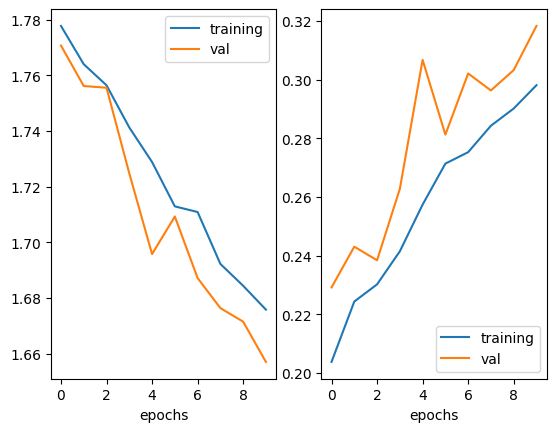

In [ ]:
training_val_loss_acc(history.history)

In [ ]:
modelo1.save('assets/Base-de-datos/modelo_0.keras')

### Modelo pre entrenado

In [ ]:
pre_model = tf.keras.applications.ResNet50V2(
    input_shape = (IMG_H, IMG_W, 3),
    include_top = False,
    weights = 'imagenet',
)

pre_model = tf.keras.Sequential([
    normalize, # normalize on training and inference
    augmentation, # data augmentation only during training
    # Convolucion y Pooling
    pre_model,
    # Capas densas y salida
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(132, activation="relu"),
    tf.keras.layers.Dense(6, activation='softmax')
])

pre_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pre_history = pre_model.fit(train, batch_size=batch_size, epochs=10, validation_data=val)

Epoch 1/10
93/93 [==============================] - 1080s 11s/step - loss: 1.2989 - accuracy: 0.5008 - val_loss: 1.5143 - val_accuracy: 0.5579
Epoch 2/10
93/93 [==============================] - 1060s 11s/step - loss: 0.9989 - accuracy: 0.6249 - val_loss: 1.0191 - val_accuracy: 0.6597
Epoch 3/10
93/93 [==============================] - 1088s 12s/step - loss: 0.8833 - accuracy: 0.6779 - val_loss: 1.1347 - val_accuracy: 0.6238
Epoch 4/10
93/93 [==============================] - 1063s 11s/step - loss: 0.8102 - accuracy: 0.6982 - val_loss: 0.9785 - val_accuracy: 0.6782
Epoch 5/10
93/93 [==============================] - 1048s 11s/step - loss: 0.7514 - accuracy: 0.7258 - val_loss: 1.0167 - val_accuracy: 0.6817
Epoch 6/10
93/93 [==============================] - 1041s 11s/step - loss: 0.7007 - accuracy: 0.7423 - val_loss: 1.3720 - val_accuracy: 0.6273
Epoch 7/10
93/93 [==============================] - 1045s 11s/step - loss: 0.6607 - accuracy: 0.7569 - val_loss: 1.2573 - val_accuracy: 0.6435

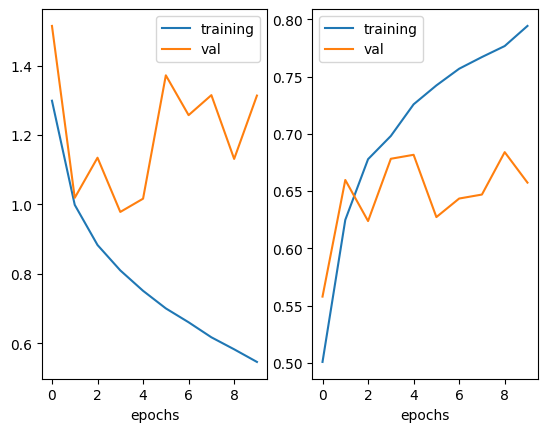

In [ ]:
training_val_loss_acc(pre_history.history)

In [ ]:
pre_model.save('assets/Base-de-datos/pre_modelo.keras')

### Cargar modelos

In [ ]:
modelo_desde_cero = tf.keras.models.load_model('assets/Base-de-datos/modelo_0.keras', compile=True)
pre_modelo_carga = tf.keras.models.load_model('assets/Base-de-datos/pre_modelo.keras', compile=True)
teachable_model = tf.keras.models.load_model('assets/Base-de-datos/keras_model.h5', compile=False)

In [ ]:
teachable_input = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_H, IMG_W),
  tf.keras.layers.Rescaling(1./127.5, offset=-1)
])
teachable_test = test.map(lambda x, y: (teachable_input(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

# Teachable Machine se cargo con otro orden de clases entonces para corregir existe este dict
scrambled = {
  0: 4, # 0 es jet en TM y 4 en TF
  1: 5, # 1 es misil en TM y 5 en TF
  2: 3, # 2 es helicoptero en TM y 3 en TF
  3: 2, # 3 es dron en TM y 2 en TF
  4: 1, # 4 es cohete en TM y 1 en TF
  5: 0, # 5 es avion en TM y 0 en TF
}

correct = 0
total = 0
for (x, y) in teachable_test:
    np_y = np.asarray(y)
    np_x = np.asarray(x)
    for i in range(len(np_y)):
        total += 1
        data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
        data[0] = np.asarray(np_x[i])
        prediction = teachable_model.predict(data)
        index = np.argmax(prediction)
        if (scrambled[index] == np_y[i]):
            correct += 1

print(f'accuracy = {correct/total}')

1/1 [==============================] - 0s 30ms/step
accuracy = 0.69125


In [ ]:
cero_result = modelo_desde_cero.evaluate(test)

12/12 [==============================] - 8s 419ms/step - loss: 1.6452 - accuracy: 0.3262


In [ ]:
pre_load_result = pre_modelo_carga.evaluate(test)

12/12 [==============================] - 24s 2s/step - loss: 1.3508 - accuracy: 0.6513


### Código de Teachable Machine para predecir imágenes

In [ ]:
from PIL import Image, ImageOps
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the labels
class_names = open("assets/Base-de-datos/labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open("assets/Base-de-datos/datos/objetos/helicoptero/00000865.jpeg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = teachable_model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)

1/1 [==============================] - 0s 40ms/step
Class: helicoptero
Confidence Score: 0.6594137
